In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker

import MDSplus as mds

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sp

In [4]:
plt.rcParams['mathtext.default'] = 'regular'

# <b>the only thing you need to input is the date and shot number!!!</b>
date is the date recorded in the log on which you did the experiment, apparently,

shot number is the shot number in that day, recorded in the log.

For other things the code will automatically do it for you!

In [5]:
# date = 240619
# shot_in_the_date = 27

# <b>Loading the TS-6 log</b>
load the TS-6 log.

All the experiment parameters should be there

In [6]:
sheet_id = '1wG5fBaiQ7-jOzOI-2pkPAeV6SDiHc_LrOdcbWlvhHBw'
url = f'https://docs.google.com/spreadsheets/d/%s/export?format=csv' %sheet_id

In [7]:
exp_log = pd.read_csv(url)

In [8]:
def read_parameter(date, shot_in_the_date):
    '''
    this function read the experiment parameters which was taken in 'date', with a shot number 'shot_in_the_date'
    '''
    
    # reading TS-6 log, where date is 'date'(user input value) and shot is shot_in_the_date
    exp_in = exp_log.query('date=="%s" and shot=="%s"' %(date, shot_in_the_date))
    
    # the following code reads the parameter for you
    shot = exp_in['a039'].astype(int).iloc[0]
    tfshot = exp_in['a039_TF'].astype(int).iloc[0]
    exp_in = exp_in.infer_objects(copy=False).fillna(0)
    I_EF = exp_in['EF[A]'].astype(int).iloc[0]
    TF_voltage = exp_in['TF[kV]'].astype(int).iloc[0]

    return shot, tfshot, I_EF, TF_voltage

# <b>Connecting to MDSPlus data</b>
Our magnetic probe data is usually stored in the fourier surver, managed by MDSPlus.

this part of code will do the following for you:
1. it tries to load the local data in the following path: './\\$date\\$/\\$shot_in_the_day\\$.csv'
   
2. if the above fails it will connect to MDSplus and get the data for you, process them, and save the data in the above path(create one if it doesn't exist)

In [9]:
dgt_ch_dic = {39:192, 40:120} # a dictionary which store the number of the digitizer's channels 

dgt_no = 39 # digitizer number

dgt_ch_no = dgt_ch_dic[dgt_no] # the number of the digitizer' channels

In [69]:
def read_data(date, shot_in_the_date):
    '''
    this function returns the rawdate which was taken in 'date', with a shot number 'shot_in_the_date'
    '''

    shot, tfshot, I_EF, TF_voltage = read_parameter(date, shot_in_the_date)

    try:
        
        rawdata = np.genfromtxt('./%s/shot%s.csv' %(date, shot_in_the_date), delimiter=',')
        
    except FileNotFoundError:
    
        
        conn = mds.Connection('192.168.1.140')
        
        
        rawdata = np.empty([1000, dgt_ch_no]) # rawdata is to hold the data that is originally stored in Fourier
        
        conn.openTree('a%03i' %dgt_no, shot) # loading the shot data
        for i in range(dgt_ch_no):
            rawdata[:, i] = conn.get('AI:CH%03i' %(i+1))
        rawdata = rawdata - rawdata[0, :] # clear out the offset
    
        rawdata_tf = np.zeros_like(rawdata) # again, to hold the tfshot rawdata
        
        if tfshot != 0:
            conn.openTree('a%03i' %dgt_no, tfshot) # loading the tfshot data
            for i in range(dgt_ch_no):
                rawdata_tf[:, i] = conn.get('AI:CH%03i' %(i+1))
            rawdata_tf = rawdata_tf - rawdata_tf[0, :] # clear out the offset

            rawdata = rawdata - rawdata_tf # the useful, processable data
    
        
    
        
        try:
            np.savetxt('./%s/shot%s.csv' %(date, shot_in_the_date), rawdata, delimiter=',')
        except FileNotFoundError:
            os.mkdir('./%s' %date)
            np.savetxt('./%s/shot%s.csv' %(date, shot_in_the_date), rawdata, delimiter=',')

    
    return rawdata #notice the indent here...

# <b>Let's start the happy data cleaning!!!</b>
In short, the algorithm does the following:
1. take the $B_z$ data
1. interpolate the $B_z$ data
2. use the $B_z$ data to calculat $\psi$
3. use the $\psi$ to derive other physical properties

So to make sure the algorithm works propoerly, the calibration needs to do the following:
1. extract the $B_z$ channel. Because not all channels in the magnetic probes are measuring $B_z$, some are $B_r$
2. drop out the dead channels. Some may have died during the experiments...
3. intensity and polarity calibration. Some RC/NS thing, refer to Cai San's master thesis.
---------
But more detailedly, I will try to explain how our magnetci probes in our TS-6 works, so that we can have a better understanding on how and why this code works.

So there are many probes inserting in TS-6, on each probe there are many channels(some of them measure Bt and some Bz, at different positions). Each has many coils. These coils generate voltage when magnetic field changes and this signal is sent to a integrator before it is fed into a digitizer. 

This should explain why there is probe number, probe channel, channel and digitizer channel in the calibration sheet. We have many probes, so each probe has a probe number; each probe has many channels, so there is a channel number; when all these channels are collected, they are numbered together again, which is 'ch' in the calibration sheet; <b>Finally and MOST importanly</b> is the digitizer channel, it is the channel number in the MDSplus.

After correctly extracted the channel data, the next thing is to calibrate its signal. First is to multipy it by some RC/NS, which matches the signal to a real physical quantity, for why and how doing so refer to Cai San's master thesis. And then multiply the polarity, either 1 or -1, because sometimes people just connect the positive and negative poles of the wire wrong. Finally drop out the dead channels. For some reason they just do not work...

Oh yeah!! don't forget to keep record of their positions, we need this for interpolation.

In [11]:
# the calibration file.
cali_data = pd.read_excel('/mnt/e/東大/研究/pcb_experiment/coeff200ch.xlsx', sheet_name='240619')

In [12]:
cali_data['dtacq_num'] = cali_data['dtacq_num'].ffill() #filling the missing data

In [13]:
def rawdata_calibration(date, shot_in_the_date):
    '''
    this function reads the rawdata, calibrat it, and return the calibrated one.
    '''

    rawdata = read_data(date, shot_in_the_date)
    
    # take out the calibration data where digitizer is 39, ok is not 0 and direction is z
    cali_data_alivez = cali_data.query('dtacq_num==39 and ok!=0 and direction=="z"')
    
    # take out the alive channels, remember to minus 1 because in python columns starts from 0
    rawdata_alive = rawdata[:, cali_data_alivez['dtacq_ch'].values-1]
    
    # NS and polarity calibration
    rawdata_alive = rawdata_alive * cali_data_alivez['RC/NS'].values[None, :]
    rawdata_alive = rawdata_alive * cali_data_alivez['polarity'].values[None, :]

    r_position = cali_data_alivez['rpos']
    z_position = cali_data_alivez['zpos']

    return rawdata_alive

In [14]:
def RZ_coordinate():
    '''
    return the R-Z coordinate of our measurement points.
    '''

    cali_data_alivez = cali_data.query('dtacq_num==39 and ok!=0 and direction=="z"')
    
    r_position = cali_data_alivez['rpos']
    z_position = cali_data_alivez['zpos']

    return r_position, z_position

In [15]:
def RZ_range():
    '''
    return the interpolated R and Z range of the measurement area.
    '''

    r_position, z_position = RZ_coordinate()

    
    r_interp = np.linspace(r_position.min(), r_position.max(), 40) # interpolation, for further integration
    z_interp = np.linspace(z_position.min(), z_position.max(), 50)

    return r_interp, z_interp

# <b>Interpolating</b>

In [16]:
def Bz_interp_at_t(date, shot_in_the_date, m):
    '''
    this function interpolate the mearsured Bz and return the interpolated value.
    '''
    
    rawdata_alive = rawdata_calibration(date, shot_in_the_date)

    r_position, z_position = RZ_coordinate()

    r_interp, z_interp = RZ_range()
    
    tck = interp.bisplrep(r_position, z_position, rawdata_alive[m, :])
    return interp.bisplev(r_interp, z_interp, tck)

# <b>EF field </b>
EF field is produced by the equilibrium field coils

$$B_{z, EF}=\frac{\mu_0I}{2\pi}\frac{1}{\sqrt{(R+r)^2+z^2}}\left[K(k)+\frac{R^2-r^2-z^2}{(R+r)^2+z^2-4rR}E(k)\right]$$
$$k^2=\frac{4Rr}{(R+r)^2+z^2}$$

where:

$R$ is the radius of the current loop.

$r$ is the measurement point's radial distance to the center axis of the center loop.

$z$ is the measurement point's vertical distance to the center loop's plane.

$\mu$ is the permeability constant.

$I=N\times I_{EF}$ is the current in the coils.

Finally, $E(k), K(k)$ are the canonical elliptical integral of the first and second kind.

by the way, the above equation is derived from this website:https://tiggerntatie.github.io/emagnet/offaxis/iloopoffaxis.htm

In [17]:
R_EF = 0.5
mu = 4e-7 * np.pi
n_EF = 234


Z_EF1 = 0.78 # the position of the equilibrium coils
Z_EF2 = -0.78 

In [18]:
K = lambda k: sp.ellipk(k) # the canonical elliptical integral of the first kind
E = lambda k: sp.ellipe(k) # the canonical elliptical integral of the second kind

In [19]:
def B_EF(date, shot_in_the_date, Z):
    '''
    this equation calculates the Bz field generated by the equilibrium coils.
    It only takes Z as input, which is the Z coordinates of the coils
    '''

    shot, tfshot, I_EF, TF_voltage = read_parameter(date, shot_in_the_date)
    
    I = n_EF * I_EF

    r_interp, z_interp = RZ_range()
    
    z_ef = z_interp[None, :] + Z
    r_ef = r_interp[:, None]

    k = np.sqrt(4 * R_EF * r_ef / ((R_EF+r_ef)**2 + z_ef ** 2))
    
    return I * mu  / 2 / (
                            np.pi * np.sqrt((R_EF+r_ef)**2 + z_ef**2)
                          ) * (
                            E(k)*(R_EF**2-r_ef**2-z_ef**2)/((R_EF+r_ef)**2+z_ef**2-4*R_EF*r_ef)+K(k)
                               ) ## forgive me for giving something like this....
                               ## the thing inside the first big parenthesis is the big denomiator
                               ## the thing inside the second big parenthesis is the square brackets

In [57]:
def Bz_at_t(date, shot_in_the_date, m):
    '''
    this function returns the Bz at a certain time t.
    input m is the frame number, which corresponds to t=m*1us in experiment
    '''
    return Bz_interp_at_t(date, shot_in_the_date, m) - B_EF(date, shot_in_the_date, Z_EF1) - B_EF(date, shot_in_the_date, Z_EF2)

# Plot the data

Okay!!! We made it here!!! But how do we visualize the $B_z$?

In [21]:
def RZ_mesh():
    '''
    this function returns the meshgrid of the interpolated RZ plane
    '''

    r_interp, z_interp = RZ_range()
    R_interp, Z_interp = np.meshgrid(r_interp, z_interp)

    return R_interp, Z_interp

In [22]:
def psi_at_t(date, shot_in_the_date, m):
    '''
    this function returns the psi at a certain time t.
    input m is the frame number, which corresponds to t=m*1us in experiment
    '''
    
    r_interp, z_interp = RZ_range()
    R_interp, Z_interp = RZ_mesh()
    
    return integ.cumulative_trapezoid(Bz_at_t(date, shot_in_the_date, m) * r_interp[:, None], r_interp, axis=0) * 2 * np.pi

In [53]:
def psi_plot(date, shot_in_the_date, save=True):
    '''
    this function only takes date and shot in the date as input
    and returns the psi plot
    '''

    shot, tfshot, I_EF, TF_voltage = read_parameter(date, shot_in_the_date)
    R_interp, Z_interp = RZ_mesh()

    times_to_plot = np.linspace(450, 490, 9, dtype=int)
    
    fig, ax = plt.subplots(3, 3, figsize=[6, 6])
    fig.subplots_adjust(hspace=0.3)
    
    levels = np.linspace(-10e-3, 10e-3, 90)
    
    for idx, t in enumerate(times_to_plot):
        
            i, k = [idx//3, idx%3]
    
            CS = ax[i, k].contourf(R_interp[:, 1:], Z_interp[:, 1:], psi_at_t(date, shot_in_the_date, t).T, 30, cmap='pink', levels=levels)
            ax[i, k].contour(CS, levels=CS.levels[1:-1:3], colors='k')
            ax[i, k].set_title(r'%i $\mu s$' %t)

            ax[i, k].plot(np.arange(0, 7) * 25e-3 + 9e-2, np.ones(7) * -2.1e-2, 'x', c='darkred', ms=4)
    
            if k!=0:
                ax[i, k].tick_params(labelleft=False)
            if i!=2:
                ax[i, k].tick_params(labelbottom=False)
    
    ax[2, 1].set_xlabel('R[m]')
    ax[1, 0].set_ylabel('Z[m]')
    
    cbar = fig.colorbar(CS, ax=ax, shrink=0.6)
    cbar.set_label('$\\psi$[mWb]')
    
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5e-3))
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%.1f' %(x*1e3)))
    
    
    # fig.text(0.78, 0.86, 'TF=%ikV' %TF_voltage, fontdict={'weight':'bold', 'size':12})

    fig.suptitle('%s-shot%s' %(date, shot_in_the_date), fontproperties={'weight':'bold'})

    if save:
        fig.savefig('./%s/shot%s.jpg' %(date, shot_in_the_date), dpi=600)

In [39]:
# date = 240619
# shot_in_the_date = 27

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


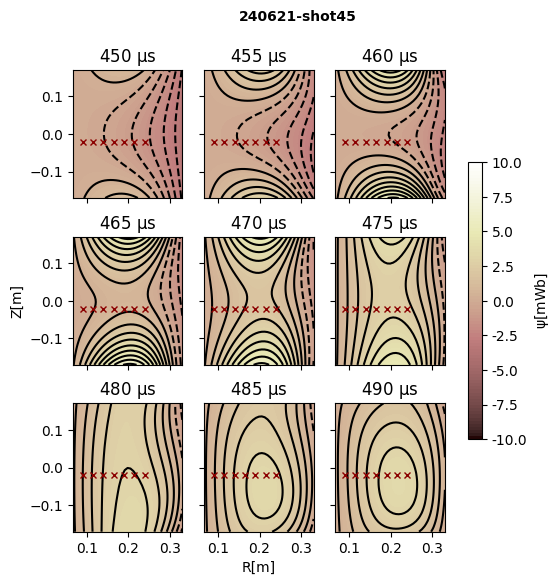

In [72]:
%time
psi_plot(240621, 45)